In [ ]:
!pip install -r ../requirements.txt

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import Dinov2Model, SegformerForSemanticSegmentation
from safetensors.torch import load_file
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.checkpoint import checkpoint as torch_checkpoint
from torchmetrics import MeanMetric
from PIL import Image
import os
import numpy as np
from dataclasses import dataclass
import random
from tqdm import tqdm
import time
import wandb

In [2]:
# ----------------------------
# Model Definitions
# ----------------------------

class SimCLR(nn.Module):
    def __init__(self, dropout_p=0.5, embedding_size=128, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        self.dropout_p = dropout_p
        self.embedding_size = embedding_size
        self.encoder = Dinov2Model.from_pretrained('microsoft/rad-dino',
                 attn_implementation="eager",   # silence the warning
                output_attentions=True)
                        
        for name, param in self.encoder.named_parameters():
            # Freeze everything by default
            param.requires_grad = False

        for name, param in self.encoder.named_parameters():
            # Unfreeze the last block and the final layernorm:
            if "encoder.layer.11" in name or "layernorm" in name:
                param.requires_grad = True

        self.projection = nn.Sequential(
            nn.Linear(768, 256),
            nn.Dropout(p=self.dropout_p),
            nn.ReLU(),
            nn.Linear(256, embedding_size)
        )

    # def forward(self, x):
    #     if not self.linear_eval:
    #         x = torch.cat(x, dim=0)
    #     outputs = self.encoder(x)
    #     encoding = outputs.last_hidden_state[:, 0]
    #     projection = self.projection(encoding)
    #     return projection

    def forward(self, x, *, return_attn=True):
        """
        If return_attn=True    -> returns (projection, attentions)
        else                   -> returns projection only
        """
        out = self.encoder(x, return_dict=True, output_attentions=return_attn)
        h = out.last_hidden_state[:, 0]          # CLS
        z = self.projection(h)
        return (z, out.attentions) if return_attn else z

In [3]:
class JointSegmentationModel(nn.Module):
    def __init__(self, base_model, composite_in_channels=7):
        super().__init__()
        # Map composite input channels to 3 channels expected by segformer
        self.input_adapter = nn.Conv2d(composite_in_channels, 3, kernel_size=1)
        self.base_model = base_model

    def forward(self, x):
        x = self.input_adapter(x)
        outputs = self.base_model(pixel_values=x, return_dict=True)
        # Upsample logits to match input resolution
        logits = F.interpolate(outputs["logits"], size=x.shape[-2:], mode="bilinear", align_corners=False)
        return logits

def dice_coef_loss(predictions, ground_truths, num_classes=4, dims=(1, 2), smooth=1e-8):
    ground_truth_oh = F.one_hot(ground_truths, num_classes=num_classes)
    prediction_norm = F.softmax(predictions, dim=1).permute(0, 2, 3, 1)
    intersection = (prediction_norm * ground_truth_oh).sum(dim=dims)
    summation = prediction_norm.sum(dim=dims) + ground_truth_oh.sum(dim=dims)
    dice = (2.0 * intersection + smooth) / (summation + smooth)
    dice_mean = dice.mean()
    CE = F.cross_entropy(predictions, ground_truths)
    return (1.0 - dice_mean) + CE

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

class JointTrainingModule(nn.Module):
    def __init__(self, retrieval_model, segmentation_model, num_classes=4, lr=1e-4,tau=0.1):
        super().__init__()
        self.retrieval_model = retrieval_model
        self.segmentation_model = segmentation_model
        self.lr = lr
        self.num_classes = num_classes
        self.tau = tau  # Temperature for the softmax

        self.cached_gallery_embeddings = None  # shape (N, D)
        self.cached_gallery_images = None     # shape (N, 3, H, W)
        self.cached_gallery_masks = None      # shape (N, H, W)

    def forward(self, query_image):
        """
        query_image:    (B, 3, H, W)
        gallery_images:(B, N, 3, H, W)
        gallery_masks: (B, N, H, W)
        Returns: guide_image, guide_mask
        """
        # -- 1) Compute query embedding
        query_embedding = self.retrieval_model(query_image)

        similarity = F.cosine_similarity(query_embedding.unsqueeze(1), self.cached_gallery_embeddings.unsqueeze(0), dim=-1)

        # -- 2) Get indices and values of the top 2 most similar gallery items
        topk_values, topk_indices = torch.topk(similarity, k=2, dim=-1)

        # -- 3) Calculate softmax weights for the top 2 values
        softmax_weights = F.softmax(topk_values / self.tau, dim=-1)

        # -- 4) Create a zero tensor for the top-k weights
        topk_weights = torch.zeros_like(similarity).float()

        # -- 5) Scatter the softmax weights into the top-k weights at the correct indices
        topk_weights.scatter_(dim=-1, index=topk_indices, src=softmax_weights)

        # -- 6) Weighted sum of the top 2 gallery images and masks
        # guide_image: (B, 3, H, W)
        guide_image = torch.einsum("bn,nchw->bchw", topk_weights, self.cached_gallery_images)
        # guide_mask: (B, H, W)
        guide_mask = torch.einsum("bn,nhw->bhw", topk_weights, self.cached_gallery_masks.float())

        return guide_image, guide_mask

In [5]:
retrieval_ckpt = '/home/saahmed/scratch/projects/Image-segmentation/retrieval/checkpoints/simclr_rad-dino_pos-pairs_aug-pairs_epochs100/best_model/'

retrieval_model_before = SimCLR(dropout_p=0.3, embedding_size=128, linear_eval=True)
# --- load the SimCLR checkpoint ( *before* joint training ) ---
retrieval_model_before.encoder.load_state_dict(load_file(os.path.join(retrieval_ckpt, "model.safetensors")))
retrieval_model_before.projection.load_state_dict(torch.load(os.path.join(retrieval_ckpt, "projection_head.pth")))

baseline_state = {k: v.clone() for k, v in retrieval_model_before.state_dict().items()}

/tmp/ipykernel_3356102/2932616699.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retrieval_model_before.projection.load_state_dict(torch.load(os.path.join(retrieval_ckp

In [6]:
retrieval_ckpt = '/home/saahmed/scratch/projects/Image-segmentation/retrieval/checkpoints/simclr_rad-dino_pos-pairs_aug-pairs_epochs100/best_model/'

retrieval_model_after = SimCLR(dropout_p=0.3, embedding_size=128, linear_eval=True)
retrieval_model_after.encoder.load_state_dict(load_file(os.path.join(retrieval_ckpt, "model.safetensors")))
retrieval_model_after.projection.load_state_dict(torch.load(os.path.join(retrieval_ckpt, "projection_head.pth")))

/tmp/ipykernel_3356102/4106438202.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retrieval_model_after.projection.load_state_dict(torch.load(os.path.join(retrieval_ckpt

<All keys matched successfully>

In [7]:
ckpt_path = '/scratch/saahmed/projects/Image-segmentation/segmentation/lightning_logs/version_0/checkpoints/ckpt_053-vloss_0.1769_vf1_0.9259.ckpt'
checkpoint = torch.load(ckpt_path, map_location="cuda:0")
state_dict = checkpoint["state_dict"]
new_state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}
config = SegformerForSemanticSegmentation.config_class.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")
config.num_labels = 4
segformer_base = SegformerForSemanticSegmentation(config)
segformer_base.load_state_dict(new_state_dict)
segmentation_model = JointSegmentationModel(segformer_base, composite_in_channels=7)

/tmp/ipykernel_3356102/2598794727.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location="cuda:0")


In [8]:
# ------------- now build the joint module --------------------
joint_ckpt = "/scratch/saahmed/projects/Image-segmentation/JointTraining/joint_training_guide_Top2/best_checkpoint_epoch_22.pth"

joint_module = JointTrainingModule(retrieval_model_after, segmentation_model, num_classes=4, lr=1e-4)

joint_module.load_state_dict(torch.load(joint_ckpt)["model_state_dict"])
fine_state = joint_module.retrieval_model.state_dict()

/tmp/ipykernel_3356102/580032358.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  joint_module.load_state_dict(torch.load(joint_ckpt)["model_state_dict"])


In [9]:
# ------------- compute deltas --------------------------------
diffs = []
for k in baseline_state:
    if baseline_state[k].dtype.is_floating_point:
        delta = (baseline_state[k] - fine_state[k]).norm().item()
        diffs.append({"param": k, "Δ‖w‖₂": delta})

import pandas as pd
df = pd.DataFrame(diffs).sort_values("Δ‖w‖₂", ascending=False)


In [10]:
df.head(24)

,param,Δ‖w‖₂
216,encoder.encoder.layer.11.mlp.fc1.weight,11.484440
218,encoder.encoder.layer.11.mlp.fc2.weight,7.132465
211,encoder.encoder.layer.11.attention.output.dens...,4.329547
207,encoder.encoder.layer.11.attention.attention.k...,3.982080
209,encoder.encoder.layer.11.attention.attention.v...,3.628670
205,encoder.encoder.layer.11.attention.attention.q...,3.507692
223,projection.0.weight,3.175758
225,projection.3.weight,1.300384
217,encoder.encoder.layer.11.mlp.fc1.bias,0.630511
213,encoder.encoder.layer.11.layer_scale1.lambda1,0.191934


In [11]:
import torch, cv2, numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T


def convert_to_rgb(img):
    return img.convert("RGB")
   
# --- preprocessing -----------------------------------------------------------
to_tensor = T.Compose([
    T.Resize((256, 256)),
    T.Lambda(convert_to_rgb),
    T.ToTensor(),                       # (C,H,W) in [0,1]
])


def vit_cls_attention_map(simclr_model, pil_img):
    simclr_model.eval()
    with torch.no_grad():
        x = to_tensor(pil_img).unsqueeze(0)
        _, attns = simclr_model(x)                # <- receives (projection, list)
    attn = attns[-1]                              # last block: (B,H,N,N)
    cls_attn = attn[0, :, 0, 1:].mean(0)          # (N-1,)
    side = int(cls_attn.numel() ** 0.5)           # 14 for 224² / 16²
    mask = cls_attn.reshape(side, side).cpu().numpy()
    mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_CUBIC)
    mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)
    return mask

# def overlay_heatmap(pil_img, mask, alpha=0.6):
#     heat = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
#     heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
#     return cv2.addWeighted(np.array(pil_img.resize((256,256))), 1-alpha, heat, alpha, 0)

def overlay_heatmap(pil_img, mask, alpha=0.6):
    """Overlay a [0,1] attention mask on a PIL image and return an RGB array."""
    pil_img = pil_img.convert("RGB").resize((256,256))   # ensure 3‑channel & same size
    img_arr = np.array(pil_img)

    heat = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)         # OpenCV → RGB

    blended = cv2.addWeighted(img_arr, 1 - alpha, heat, alpha, 0)
    return blended

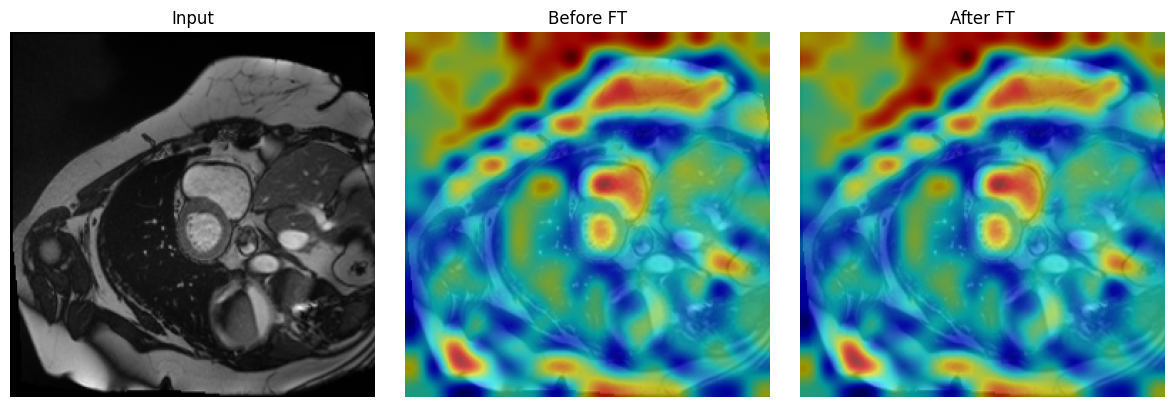

In [18]:
# path to any test image (RGB)
img_path = "../../datasets/ACDC/processed_data/Testing/ed/images/patient102_frame01_slice_1.png"
img = Image.open(img_path)

mask_before = vit_cls_attention_map(retrieval_model_before, img)
mask_after  = vit_cls_attention_map(joint_module.retrieval_model,  img)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img.resize((256,256)),cmap='gray');             
ax[0].set_title("Input");       
ax[0].axis("off")

ax[1].imshow(overlay_heatmap(img, mask_before)); 
ax[1].set_title("Before FT");   ax[1].axis("off")

ax[2].imshow(overlay_heatmap(img, mask_after));  
ax[2].set_title("After FT");    ax[2].axis("off")
plt.tight_layout(); plt.show()
